In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set();

import itertools
import shap
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate

import warnings
warnings.filterwarnings('ignore')

## Задание 1

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/katarina74/ml_lessons/main/lesson_2/data/techparams_train.csv")
X = df.drop(["target", "index"], axis=1)
y = df[["target"]]
train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.33, random_state=42)

In [3]:
train_cut_X = train_X[train_X.columns[:5]]
test_cut_X = test_X[train_X.columns[:5]]

reg = LinearRegression().fit(train_cut_X, train_y)

#расчет значений Шепли ручками
def meaning_shapley(calc_model, data_feat, example):

    signs = data_feat.columns
    len_signs = len(signs)
    shapley = {sign: 0 for sign in signs}
    
    #делаем перебор
    for sign in signs:
        other_signs = [s for s in signs if s != sign]
        for size in range(len(other_signs) + 1):
            for subset in itertools.combinations(other_signs, size):
                subset = list(subset)
                
                #работаем с подмножеством S
                data_feat_S = np.zeros((1, len_signs))
                data_feat_S[:, [list(signs).index(s) for s in subset]] = example[subset].values
                pred_S = calc_model.predict(data_feat_S)[0]
                
                #работаем с S ∪ {i}
                data_feat_S_union_i = data_feat_S.copy()
                data_feat_S_union_i[:, list(signs).index(sign)] = example[sign]
                pred_S_union_i = calc_model.predict(data_feat_S_union_i)[0]
                
                #работаем с i
                weight_sign = np.math.factorial(len(subset)) * np.math.factorial(len_signs - len(subset) - 1) / np.math.factorial(len_signs)
                shapley[sign] += weight_sign * (pred_S_union_i - pred_S)
    
    return shapley

example = test_cut_X.iloc[0]
data = meaning_shapley(reg, test_cut_X, example)

shap_df = pd.DataFrame(list(data.items()), columns=['sign', 'value'])
shap_df['value'] = shap_df['value'].astype(float).abs()
shap_df = shap_df.sort_values(by='value', ascending=False)
shap_df

,sign,value
0,back-suspension,108.887430
2,charge-time,7.074607
4,consumption-mixed,4.956284
1,battery-capacity,2.461782
3,compression,0.094038


## Задание 2

Text(0.5, 1.0, 'Пермутационная важность')

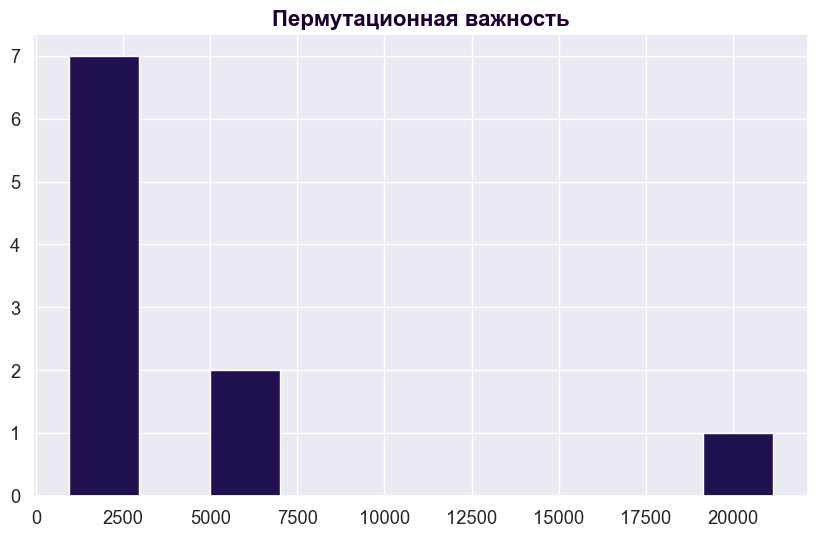

In [4]:
reg = LinearRegression().fit(train_X, train_y)

mse_0 = mean_squared_error(test_y, reg.predict(test_X))

def impor_permutation(base_model, test_x, test_y, metric=mean_squared_error, repeats=10, random_state=42):
    np.random.seed(random_state)
    signs_imp = {sign: [] for sign in test_x.columns}
    
    for _ in range(repeats):
        for sign in test_x.columns:
            perm_x = test_x.copy() #делаем копию
            
            perm_x[sign] = np.random.permutation(perm_x[sign]) #перемешиваем данные
            perm_score = metric(test_y, base_model.predict(perm_x)) #предсказание и расчет
            signs_imp[sign].append(perm_score - mse_0) #сохраняем результат
    
    for sign in signs_imp: #усредняем полученные рультаты
        signs_imp[sign] = np.mean(signs_imp[sign])
    
    return signs_imp

#пермутационная важность
perm_importance = impor_permutation(reg, test_X, test_y)
data_perm = pd.DataFrame(list(perm_importance.items()), columns=['sign', 'value'])

#сортируем по убыванию
sns.set_theme(style="darkgrid", font_scale=1.2, palette='magma')
data_perm.sort_values(by='value', ascending=False).head(10)
data_perm_10 = data_perm.sort_values(by='value', ascending=False).head(10)
plt.figure(figsize=(10, 6))
data_perm_10['value'].hist()
plt.title('Пермутационная важность', fontsize=16, color='#1d0033', weight='bold')

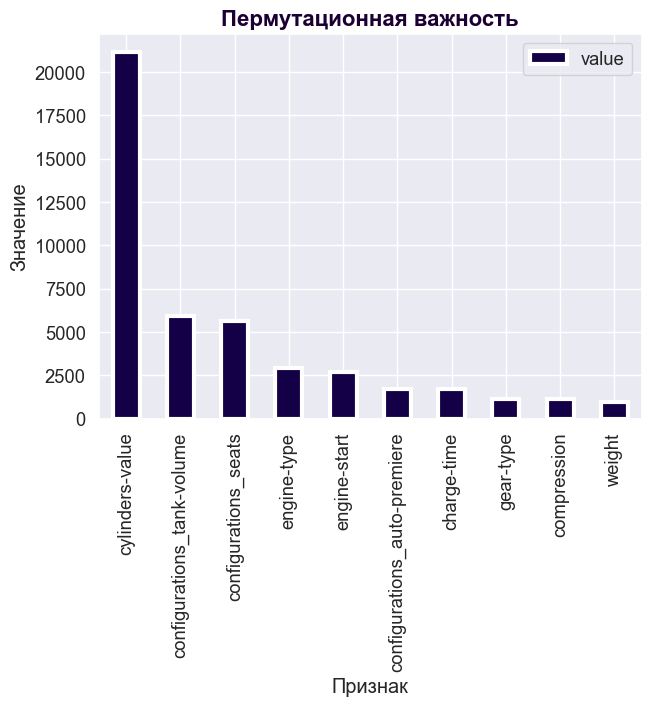

In [5]:
data_perm_10_gr = data_perm_10.plot(kind='bar',
                  color='#130047',
                  linewidth=3,
                  figsize=(7, 5),
                  legend=True,
                  y='value',
                  x='sign',
                  ylabel='Значение',
                  xlabel='Признак')
plt.title(f"Пермутационная важность", fontsize=16, color='#1d0033', weight='bold')
plt.show()